<img heigth="8" src="https://i.imgur.com/5VTYUPE.png" alt="banner">

<h1 align="left">Extremely Rare Event Classification</h1>

<p align="left"><i>A technical test for credit card fraud detection as extremely rare event classification that stays robust under real-world data quirks.</i></p>

<p align="left">
  <a href="https://joefavergel.github.io">Joseph F. Vergel-Becerra</a>
  <br>
  <b>Last updated:</b> <i>29/10/2025</i>
  <br><br>
  <a target="_blank">
    <img src="https://github.com/QData/TextAttack/workflows/Github%20PyTest/badge.svg" alt="Testing">
  </a>
  <a href="https://img.shields.io/badge/version-0.1.0-blue.svg?cacheSeconds=2592000">
    <img src="https://img.shields.io/badge/version-0.1.0-blue.svg?cacheSeconds=2592000" alt="Version" height="18">
  </a>
</p><br>
<p align="left">
  <a href="#introduction">Introduction</a><br>
  <a href="#1-data-adquisition">1. Data Adquisition</a><br>
  <a href="#2-exploratory-data-analysis">2. Exploratory Data Analysis</a><br>
  <a href="#3-preprocessing">3. Preprocessing</a><br>
  <a href="#4-training-models">4. Training Models for Extremely Rare Event Classification</a><br>
  &nbsp;&nbsp;&nbsp;<a href="#4-1-baseline-models">4.1 Baseline Models</a><br>
  &nbsp;&nbsp;&nbsp;<a href="#4-2-ensemble-models">4.2 Ensemble Models</a><br>
  &nbsp;&nbsp;&nbsp;<a href="#4-3-experimenting-with-active-learning">4.3 Experimenting with Active Learning</a><br>
  <a href="#conclusions">Conclusions</a><br>
  <br>
</p>

---

This notebook addresses credit-card fraud detection as extremely-rare-event classification. A highly imbalanced dataset is acquired, its distribution is analyzed, and recommended preprocessing techniques for predictive tasks are applied with the goal of preserving every sample in the original dataset. Baseline models (Support Vector Machine and Logistic Regression) are trained and their performance is boosted through active learning, achieving high sensitivity without sacrificing precision on real-world data.


<a id="1-data-extraction"></a>
## Introduction

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split


In [2]:
try:
    import importlib

    __package__ = "src"

    found = False
    while not found:
        os.chdir(os.path.join(os.getcwd(), os.pardir))
        found = bool(importlib.util.find_spec(__package__))
        if found:
            print(f"[INFO] WORKDIR: {os.path.join(os.getcwd(), os.pardir)}")
        continue
except ModuleNotFoundError as e:
    print("[ERROR] Verify WORKDIR execution: ", e)

[INFO] WORKDIR: /Users/joefaver/Codes/self/credit-card-fraud-test/..


In [3]:
import src
from src.utils import set_seed_everything

print(f"[INFO] Package version: {src.__version__}")

[INFO] Package version: v0.1.0


In [4]:
SEED = 42
set_seed_everything(SEED)

DATALAKE = 'datalake/'
DATA_PATH = os.path.join(DATALAKE, 'creditcard.csv')
if not os.path.exists(DATALAKE):
    os.makedirs(DATALAKE, exist_ok=True)

<a id="1-model-family-settings-validation"></a>
## 1. Data Adquisition

You can download the dataset directly from the [Kaggle: Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) competition or from this [link](https://drive.google.com/open?id=1-9-GkFnzFECQbZuFtd3SOrKzEqeJOmJ7).


In [5]:
import gdown

if not os.path.exists(DATA_PATH):
    file_id = "1-9-GkFnzFECQbZuFtd3SOrKzEqeJOmJ7"
    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, DATA_PATH, quiet=False)


In [6]:
data = pd.read_csv(DATA_PATH)
print("[INFO] Data shape:", data.shape)
data.head()

[INFO] Data shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## About Dataset

### _Context_

_"It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase."_

### _Content_

_"The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions."_

_"It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise._

_"Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification."_

<a id="2-exploratory-data-analysis"></a>
## 2. Exploratory Data Analysis

In [7]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


/var/folders/4_/n20qb35j03bb6b_f62lnx6q40000gn/T/ipykernel_1615/512719158.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data.hist(bins=100, ax=ax)


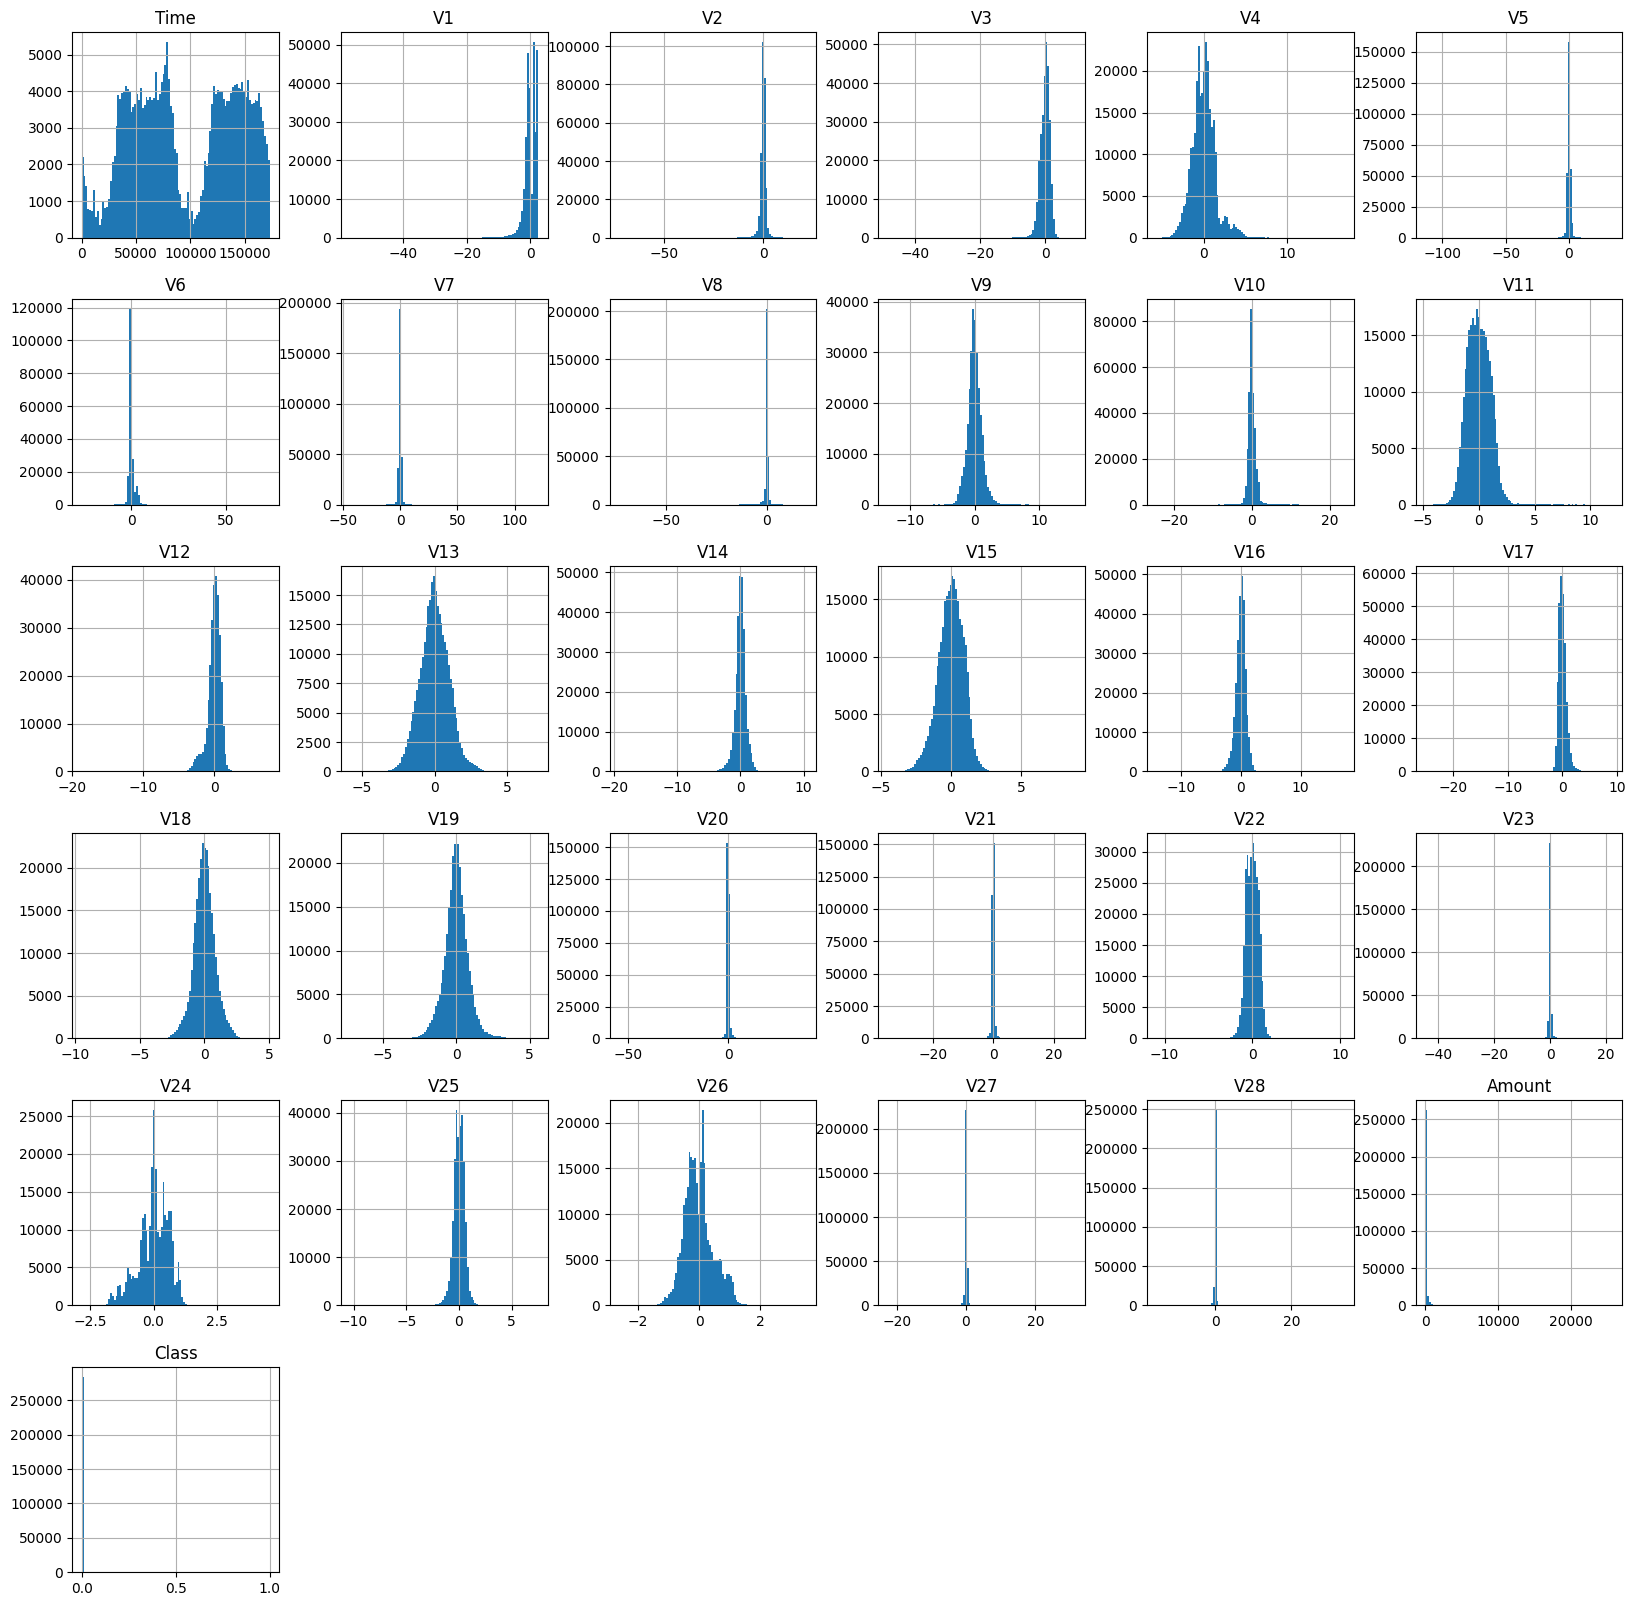

In [8]:
fig, ax = plt.subplots(figsize=(20, 20))
data.hist(bins=100, ax=ax)
plt.show()

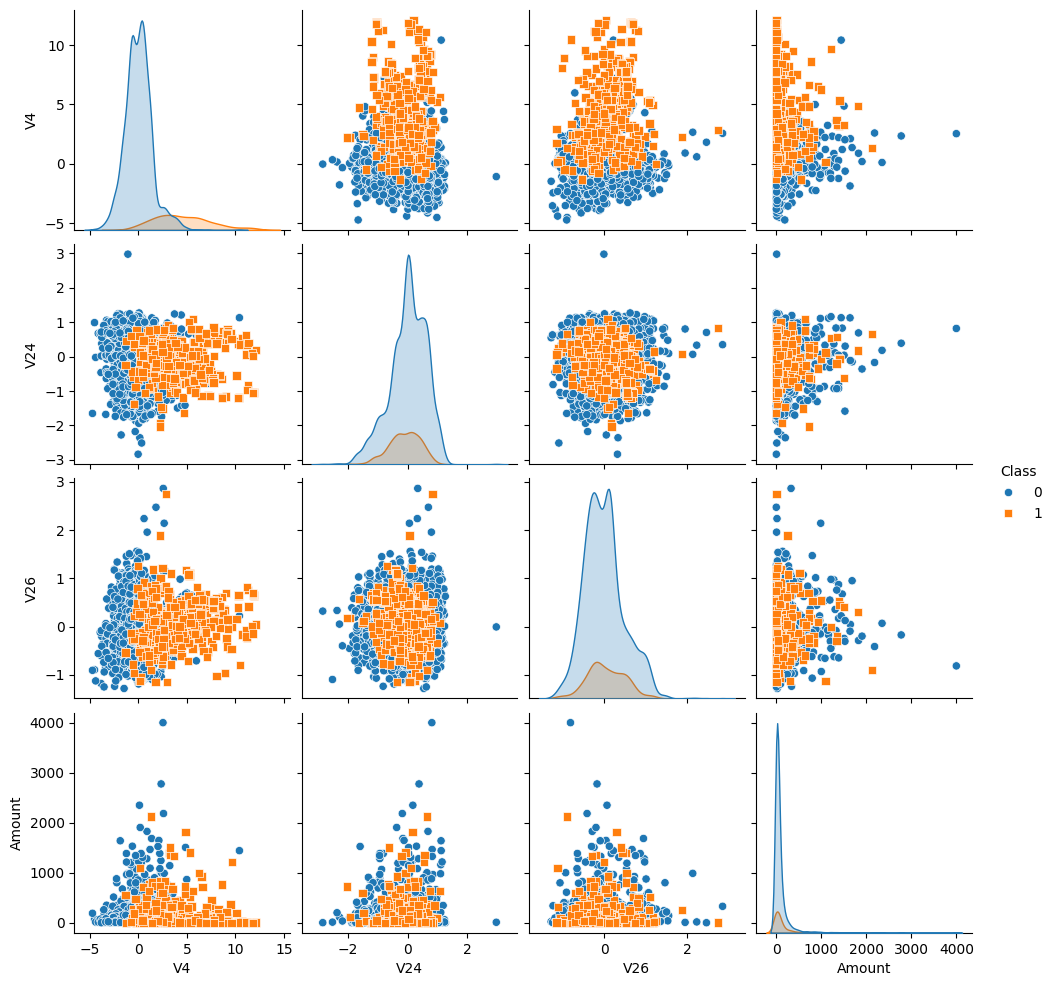

In [9]:
some_interesting_features = ['V4', 'V24', 'V26', 'Amount', 'Class']

sns.pairplot(
    pd.concat([
        data[data['Class'] == 0][some_interesting_features].sample(int(0.01 * len(data))),
        data[data['Class'] == 1][some_interesting_features]
    ], axis=0),
    hue="Class",
    markers=["o", "s"]
)
plt.show()

In [9]:
print(data['Class'].value_counts(dropna=False, normalize=True))
print(data['Class'].value_counts(dropna=False))

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64
Class
0    284315
1       492
Name: count, dtype: int64


The minority class, i.e., frauds (`'Class' == 1`), is present in only 0.172% of samples. This tells us that the predictive task is an "Extremely Rare Event Classification".


<a id="3-preprocessing"></a>
## 3. Preprocessing

The first step should be to better encode the `Time` variable. By appealing to its definition, we can better encode it as the time difference between two subsequent transactions `diff_prev_transa_time` and the time difference between two events of the same type `diff_prev_event_time`.


In [10]:
import gc
import numpy as np


data_ = data.copy()

data_['diff_prev_transa_time'] = (data_['Time'] - data_['Time'].shift(1)).replace(np.nan, 0.0)

fraud = data_[data_['Class'] == 1]
transa = data_[data_['Class'] == 0]
diff_prev_fraude_time = (fraud['Time'] - fraud['Time'].shift(1)).replace(np.nan, 0.0)
diff_prev_transa_time = (transa['Time'] - transa['Time'].shift(1)).replace(np.nan, 0.0)
data_['diff_prev_event_time'] = pd.concat([diff_prev_fraude_time, diff_prev_transa_time], axis=0).sort_index()
del fraud, transa
gc.collect()

data_.drop(['Time'], axis=1, inplace=True)

data_

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V23,V24,V25,V26,V27,V28,Amount,Class,diff_prev_transa_time,diff_prev_event_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.0,0.0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.0,0.0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,1.0,1.0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.0,0.0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0,1.0,1.0
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0,1.0,1.0
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0,1.0,1.0
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0,0.0,0.0


In [11]:
features = data_.columns.drop(['Class'])
target = 'Class'
features_to_transform = [
    'Amount', 'diff_prev_transa_time', 'diff_prev_event_time'
]
pca_features = [
    column for column in data_.columns
    if column not in features_to_transform and column != target
]

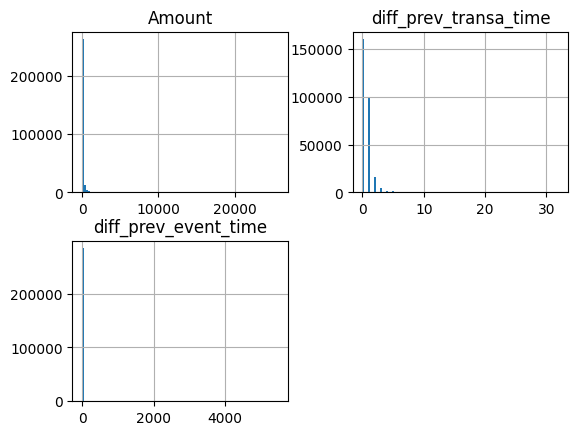

In [12]:
data_[features_to_transform].hist(bins=100)
data_
plt.show()

Now, we will proceed to scale the new features and the `Amount` variable. To do this, we will first split the dataset into training and testing sets to avoid data leakage during the scaling operation.

Additionally, we stratify based on the `Class` variable (target), so that the training and test sets contain the same proportion of frauds and normal transactions.


In [13]:
x_train, x_test, y_train, y_test = train_test_split(
    data_[features],
    data_[target],
    test_size=0.1,
    shuffle=True, 
    random_state=SEED,
    stratify=data_['Class'].to_numpy()
)
x_train

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Amount,diff_prev_transa_time,diff_prev_event_time
169217,-0.204054,0.773672,-0.508138,-0.504530,1.110237,-0.889531,0.892855,-0.129737,0.067865,-0.706473,...,-0.841090,0.345082,0.463542,-0.357763,0.117770,0.124158,0.049966,2.67,0.0,0.0
127577,1.185899,-0.777605,0.290538,-0.507296,-0.883708,-0.444648,-0.380721,-0.136399,-0.734164,0.441292,...,0.176216,-0.087076,0.117514,0.455406,-0.235654,0.009948,0.026970,101.55,0.0,0.0
155900,0.337897,-0.400062,1.397225,-0.601374,-1.432251,-0.115443,-0.791959,-0.113610,-0.818184,1.161987,...,0.177004,0.015208,-0.096025,-0.729801,0.219861,0.203869,0.166661,37.60,2.0,2.0
274954,2.035125,-0.389804,-2.551903,-0.722794,2.380486,3.320923,-0.468416,0.789462,0.402422,0.089469,...,-0.839066,0.374619,0.698594,-0.267765,0.218413,-0.053658,-0.065533,8.97,0.0,0.0
250973,1.994644,-0.343013,-0.516240,0.339995,-0.353679,-0.100897,-0.572387,-0.009577,1.255657,-0.167218,...,1.054895,0.089021,0.657755,0.014361,-0.165380,0.039714,-0.031416,10.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85418,-1.497933,0.657921,1.581568,-0.024286,0.584698,1.303031,0.609212,0.135561,0.452745,0.108640,...,0.299172,0.110048,-0.615980,-0.425883,0.263968,-0.448445,0.045178,36.99,0.0,0.0
29062,1.069777,0.072105,0.496540,1.505318,-0.380277,-0.370243,0.100551,-0.026687,0.319684,-0.131553,...,-0.044629,-0.050485,0.400171,0.593314,-0.335160,0.031014,0.024886,45.42,0.0,0.0
13766,1.280465,0.300586,0.333044,0.512720,0.065052,-0.145844,-0.145519,-0.091833,1.111187,-0.268878,...,-0.961351,0.033153,-0.560429,0.278428,0.089546,-0.059835,-0.005887,0.89,2.0,2.0
17677,-0.598120,0.775041,1.823394,0.312991,-0.096171,-0.391452,0.499351,0.071224,-0.017496,-0.512312,...,0.568083,-0.084001,0.685003,-0.245859,0.356638,0.378580,0.206366,6.99,1.0,1.0


Most distributions are skewed with very heavy tails. Therefore, we try different transformations to standardize the data that are robust to outliers.


In [14]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer


rs = RobustScaler()
rs.fit(x_train[features_to_transform])

qt = QuantileTransformer(n_quantiles=10, random_state=SEED)
qt.fit(x_train[features_to_transform])

ns = Normalizer()
ns.fit(x_train[features_to_transform])

pt = PowerTransformer()
pt.fit(x_train[features_to_transform])

PowerTransformer()

/var/folders/4_/n20qb35j03bb6b_f62lnx6q40000gn/T/ipykernel_1615/3336702930.py:17: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  scaled_x_train.hist(bins=100, ax=ax)


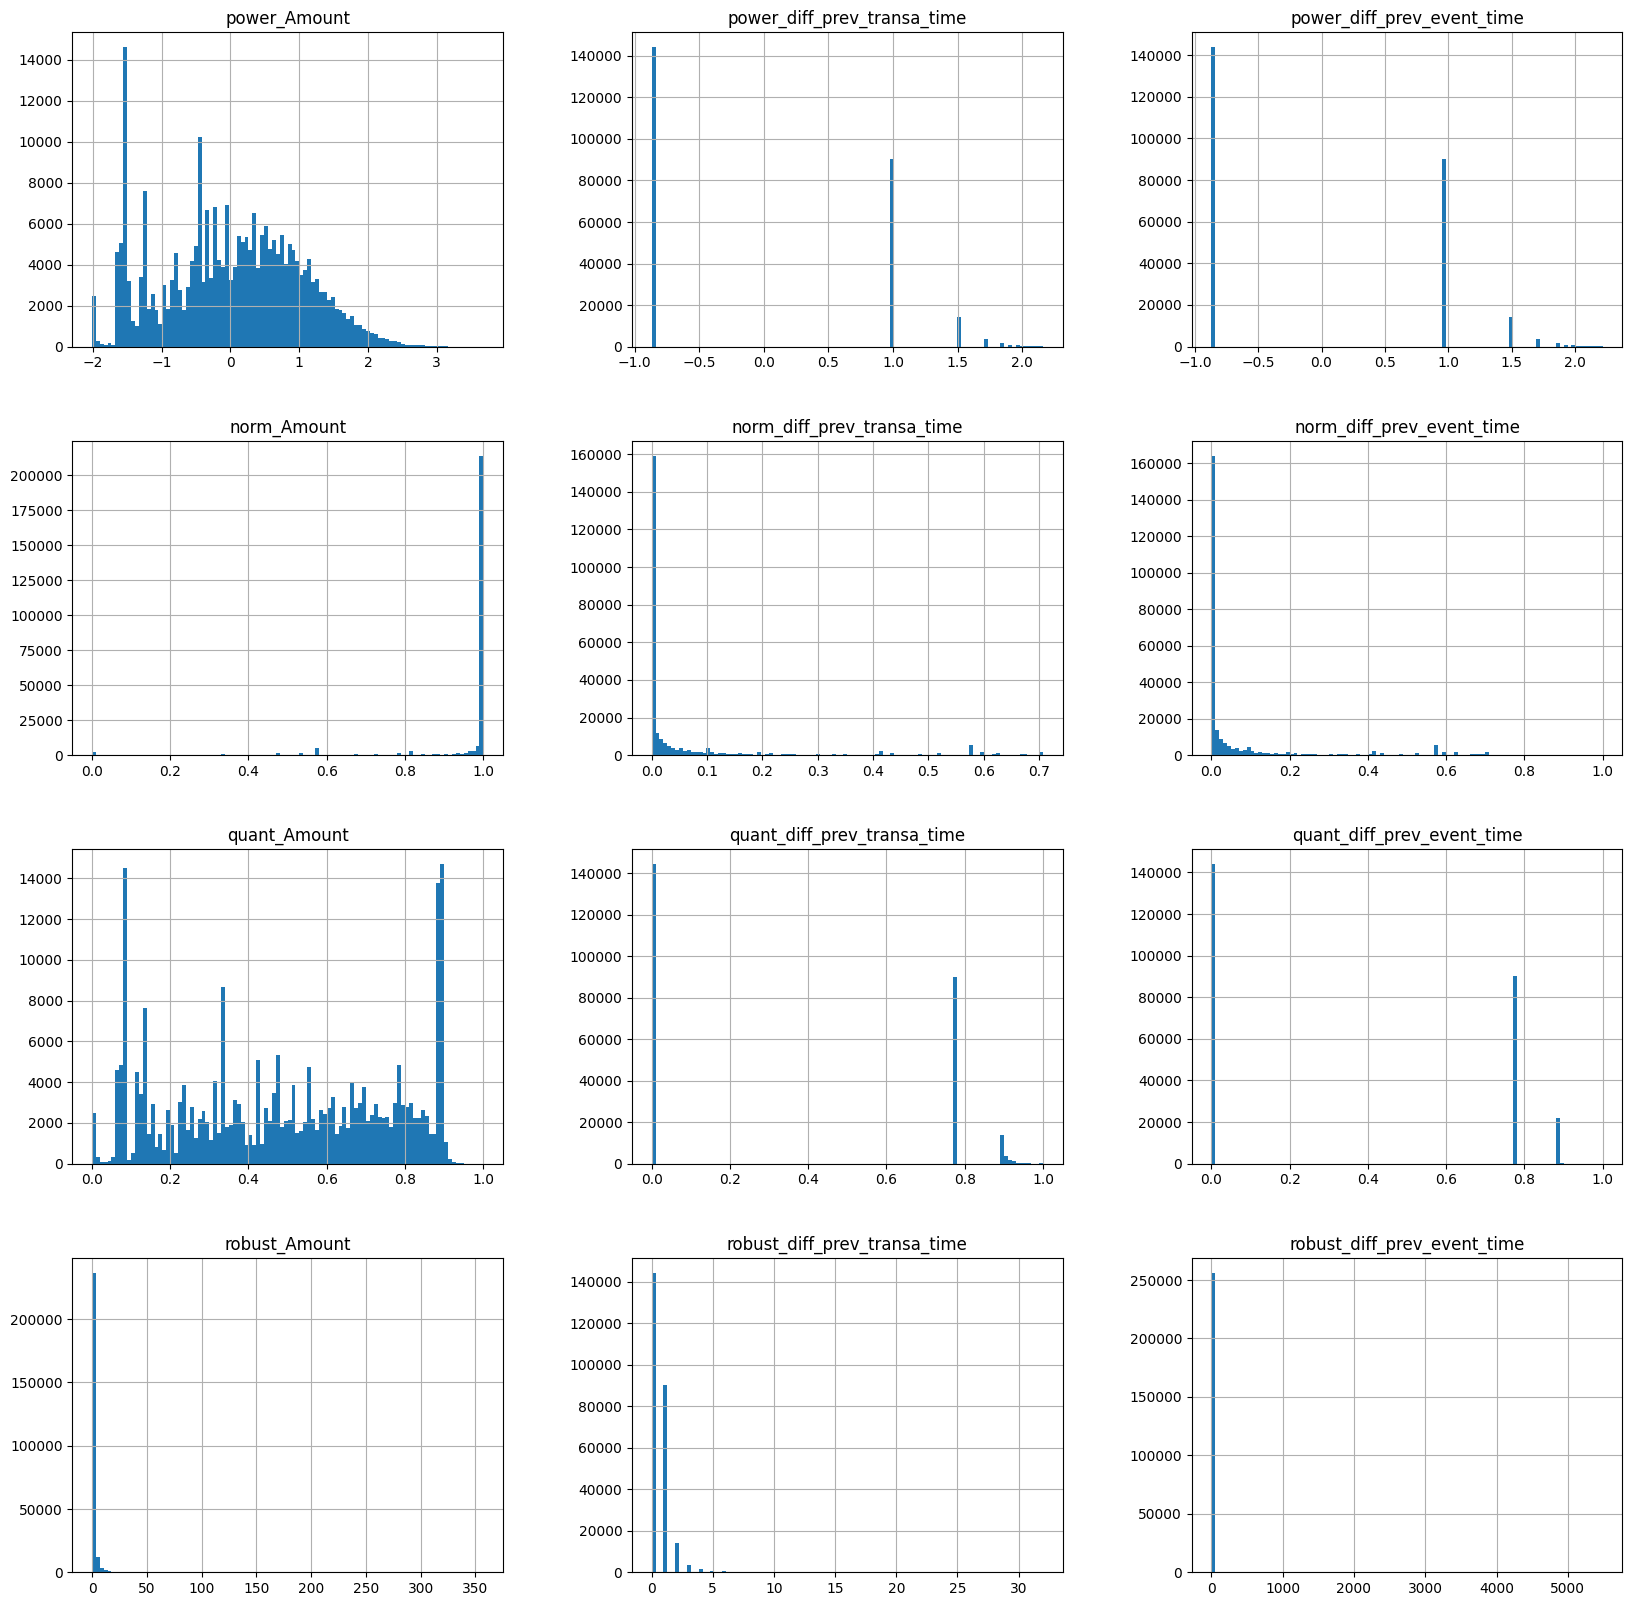

In [15]:
scaled_x_train, scaled_x_test = pd.DataFrame(), pd.DataFrame()
for method, scaler in {'robust_': rs, 'quant_': qt, 'norm_': ns, 'power_': pt}.items():
    new_cols = [method + column for column in features_to_transform]
    tmp_x_train = scaler.transform(x_train[features_to_transform])
    tmp_x_train = pd.DataFrame(tmp_x_train, columns=new_cols)
    tmp_x_train.index = x_train.index

    tmp_x_test = scaler.transform(x_test[features_to_transform])
    tmp_x_test = pd.DataFrame(tmp_x_test, columns=new_cols)
    tmp_x_test.index = x_test.index

    scaled_x_train = pd.concat([tmp_x_train, scaled_x_train], axis=1)
    scaled_x_test = pd.concat([tmp_x_test, scaled_x_test], axis=1)


fig, ax = plt.subplots(figsize=(20, 20))
scaled_x_train.hist(bins=100, ax=ax)
plt.show()

Given the scale ranges, we opted for the Box-Cox transformation.


In [16]:
best_scaler = 'power_'
scaled_features = [
    column for column in scaled_x_train.columns
    if column.startswith(best_scaler)
]

x_train = pd.concat([
    x_train[pca_features],
    scaled_x_train[scaled_features]
], axis=1)

x_test = pd.concat([
    x_test[pca_features],
    scaled_x_test[scaled_features]
], axis=1)

<a id="4-training-models"></a>
## 4. Training Models

<a id="4-1-baseline-models"></a>
### 4.1 Baseline Models

Since it is a rare-event detection task, we choose as one of our base models a `OneClassSVM` (unsupervised) to try to capture non-linear patterns in the data.


In [22]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(y_test, y_pred):
    print(classification_report(y_test, y_pred, digits=3))

    cm = confusion_matrix(y_true=y_test.values, y_pred=y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud']
    )
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

In [19]:
from sklearn.svm import OneClassSVM

features = pca_features + scaled_features

clf = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)
clf.fit(x_train[features])

OneClassSVM(gamma='auto', nu=0.05)

              precision    recall  f1-score   support

           0      1.000     0.949     0.974     28432
           1      0.030     0.918     0.059        49

    accuracy                          0.949     28481
   macro avg      0.515     0.934     0.516     28481
weighted avg      0.998     0.949     0.972     28481



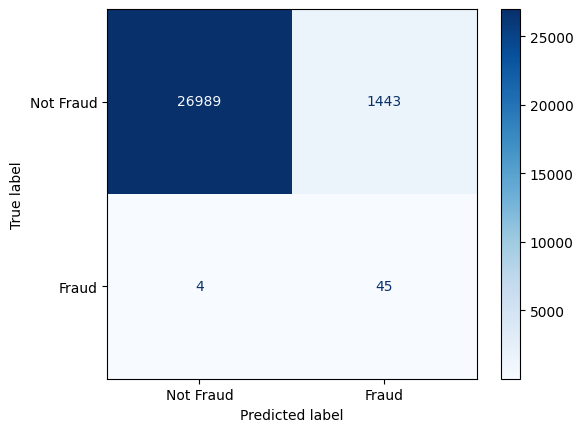

In [20]:
# OneClassSVM returns -1 for outliers and 1 for inliers.
y_pred = pd.DataFrame(data=clf.predict(x_test[features]))
y_pred.loc[y_pred[0] == 1] = 0
y_pred.loc[y_pred[0] == -1] = 1

evaluate_model(y_test, y_pred)

In [35]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(
    class_weight='balanced',
    C=0.01,
    penalty='l1',
    solver='saga',
    max_iter=1000,
    n_jobs=-1,
    random_state=SEED
).fit(x_train, y_train)

              precision    recall  f1-score   support

           0      1.000     0.999     0.999     28432
           1      0.565     0.980     0.716        49

    accuracy                          0.999     28481
   macro avg      0.782     0.989     0.858     28481
weighted avg      0.999     0.999     0.999     28481



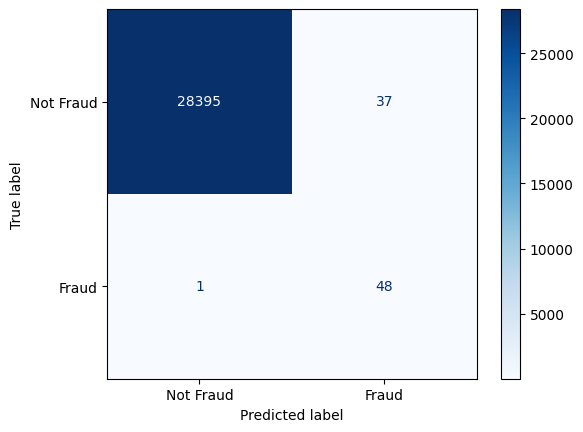

In [30]:
evaluate_model(y_test, clf.predict(x_test))

<a id="4-2-ensemble-models"></a>
### 4.2 Ensemble Models

In [ ]:
from sklearn.metrics import (
    precision_recall_curve,
    roc_auc_score,
    average_precision_score,
    f1_score,
    recall_score,
    precision_score
)
import xgboost as xgb
from typing import Dict, Optional


class XGBoostClassifierImbalanced:
    """
    XGBoost Classifier optimized for extremely imbalanced datasets.
    
    Features:
    - Automatic scale_pos_weight calculation
    - Stratified cross-validation
    - Early stopping with best model restoration
    - Threshold optimization to maximize F1/Recall
    - Evaluation with appropriate metrics for imbalance
    """

    def __init__(
        self,
        n_estimators: int = 100,
        max_depth: int = 3,
        learning_rate: float = 0.1,
        early_stopping_rounds: Optional[int] = 10,
        eval_metric: str = 'aucpr',
        random_state: int = 42,
        n_jobs: int = -1,
        verbose: bool = True
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.early_stopping_rounds = early_stopping_rounds
        self.eval_metric = eval_metric
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.verbose = verbose
        self.model = None
        self.best_iteration = None
        self.scale_pos_weight = None
        self.optimal_threshold = 0.5

    def _calculate_scale_pos_weight(self, y: pd.Series) -> float:
        """Calculate the weight to balance classes."""
        n_negative = (y == 0).sum()
        n_positive = (y == 1).sum()
        return n_negative / n_positive

    def fit(
        self, 
        X_train: pd.DataFrame, 
        y_train: pd.Series,
        X_valid: Optional[pd.DataFrame] = None,
        y_valid: Optional[pd.Series] = None,
        auto_scale_weight: bool = True
    ):
        """
        Train the XGBoost model.
        
        Args:
            X_train: Training features
            y_train: Training target
            X_valid: Validation features (optional)
            y_valid: Validation target (optional)
            auto_scale_weight: Automatically calculate scale_pos_weight
        """
        if auto_scale_weight:
            self.scale_pos_weight = self._calculate_scale_pos_weight(y_train)
            if self.verbose:
                print(f"[INFO] Calculated scale_pos_weight: {self.scale_pos_weight:.2f}")

        params = {
            'objective': 'binary:logistic',
            'eval_metric': self.eval_metric,
            'max_depth': self.max_depth,
            'learning_rate': self.learning_rate,
            'scale_pos_weight': self.scale_pos_weight,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': self.random_state,
            'n_jobs': self.n_jobs,
            'tree_method': 'hist'  # Faster for large datasets
        }

        dtrain = xgb.DMatrix(X_train, label=y_train)
        evals = [(dtrain, 'train')]

        if X_valid is not None and y_valid is not None:
            dvalid = xgb.DMatrix(X_valid, label=y_valid)
            evals.append((dvalid, 'valid'))

        if self.verbose:
            print(f"\n[INFO] Training XGBoost...")
            print(f"  - Train samples: {len(X_train)} (Fraud: {y_train.sum()})")
            if X_valid is not None:
                print(f"  - Valid samples: {len(X_valid)} (Fraud: {y_valid.sum()})")

        evals_result = {}
        self.model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=self.n_estimators,
            evals=evals,
            early_stopping_rounds=self.early_stopping_rounds,
            evals_result=evals_result,
            verbose_eval=10 if self.verbose else False
        )

        self.best_iteration = self.model.best_iteration

        if self.verbose:
            print(f"\n[INFO] Training completed!")
            print(f"  - Best iteration: {self.best_iteration}")
            print(f"  - Best score: {self.model.best_score:.4f}")

        # return self

    def predict_proba(self, X: pd.DataFrame) -> np.ndarray:
        """Return probabilities of the positive class."""
        if self.model is None:
            raise ValueError("Model not trained. Call fit() first.")

        dtest = xgb.DMatrix(X)
        proba = self.model.predict(dtest)
        return proba

    def predict(self, X: pd.DataFrame, threshold: Optional[float] = None) -> np.ndarray:
        """
        Predict binary classes.
        
        Args:
            X: Features
            threshold: Decision threshold. If None, uses self.optimal_threshold
        """
        if threshold is None:
            threshold = self.optimal_threshold

        proba = self.predict_proba(X)
        return (proba >= threshold).astype(int)

    def optimize_threshold(
        self,
        X_valid: pd.DataFrame,
        y_valid: pd.Series,
        strategy: str = 'f1',
        min_recall: float = 0.0
    ) -> float:
        """
        Optimize the decision threshold.
        
        Args:
            X_valid: Validation features
            y_valid: Validation target
            strategy: 'f1' (maximize F1) or 'recall' (minimum recall)
            min_recall: Minimum required recall (only for strategy='recall')
            
        Returns:
            Optimal threshold
        """
        y_proba = self.predict_proba(X_valid)

        precisions, recalls, thresholds = precision_recall_curve(y_valid, y_proba)

        if strategy == 'f1':
            # Maximizar F1-score
            f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
            optimal_idx = np.argmax(f1_scores)
            self.optimal_threshold = thresholds[optimal_idx]

            if self.verbose:
                print(f"\n[INFO] Threshold Optimization (Strategy: F1)")
                print(f"  - Optimal threshold: {self.optimal_threshold:.3f}")
                print(f"  - F1-Score: {f1_scores[optimal_idx]:.3f}")
                print(f"  - Recall: {recalls[optimal_idx]:.3f}")
                print(f"  - Precision: {precisions[optimal_idx]:.3f}")

        elif strategy == 'recall':
            # Maximizar precision con recall mínimo
            valid_idx = recalls >= min_recall
            if valid_idx.any():
                valid_precisions = precisions[valid_idx]
                optimal_idx = np.argmax(valid_precisions)
                optimal_global_idx = np.where(valid_idx)[0][optimal_idx]
                self.optimal_threshold = thresholds[optimal_global_idx]

                if self.verbose:
                    print(f"\n[INFO] Threshold Optimization (Strategy: Recall >= {min_recall})")
                    print(f"  - Optimal threshold: {self.optimal_threshold:.3f}")
                    print(f"  - Recall: {recalls[optimal_global_idx]:.3f}")
                    print(f"  - Precision: {precisions[optimal_global_idx]:.3f}")
            else:
                print(f"[WARNING] No threshold achieves recall >= {min_recall}")
                self.optimal_threshold = 0.01  # Threshold muy bajo

        return self.optimal_threshold

    def evaluate(
        self,
        X_test: pd.DataFrame,
        y_test: pd.Series,
        threshold: Optional[float] = None,
        show_plots: bool = True
    ) -> Dict[str, float]:
        if threshold is None:
            threshold = self.optimal_threshold

        y_proba = self.predict_proba(X_test)
        y_pred = (y_proba >= threshold).astype(int)

        # Calcular métricas
        metrics = {
            'threshold': threshold,
            'roc_auc': roc_auc_score(y_test, y_proba),
            'pr_auc': average_precision_score(y_test, y_proba),
            'f1_score': f1_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
        }

        # Confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        metrics.update({
            'TP': int(tp), 'FP': int(fp),
            'FN': int(fn), 'TN': int(tn)
        })

        if self.verbose:
            print(f"\n[INFO] Evaluation Results (threshold={threshold:.3f})")
            print(f"  ROC-AUC:    {metrics['roc_auc']:.4f}")
            print(f"  PR-AUC:     {metrics['pr_auc']:.4f}")
            print(f"  F1-Score:   {metrics['f1_score']:.4f}")
            print(f"  Recall:     {metrics['recall']:.4f}")
            print(f"  Precision:  {metrics['precision']:.4f}")

        if show_plots:
            evaluate_model(y_test, y_pred)

        return metrics

    def get_feature_importance(
        self,
        importance_type: str = 'weight',
        top_n: int = 20
    ) -> pd.DataFrame:
        """
        Get feature importance.
        
        Args:
            importance_type: 'weight', 'gain', or 'cover'
            top_n: Top N features to display
        """
        if self.model is None:
            raise ValueError("Model not trained. Call fit() first.")

        importance = self.model.get_score(importance_type=importance_type)
        importance_df = pd.DataFrame({
            'feature': importance.keys(),
            'importance': importance.values()
        }).sort_values('importance', ascending=False).head(top_n)

        return importance_df


[INFO] Dataset split:
  Train:  230693 samples (399 frauds)
  Valid:  25633 samples (44 frauds)
  Test:   28481 samples (49 frauds)
[INFO] Calculated scale_pos_weight: 577.18

[INFO] Training XGBoost...
  - Train samples: 230693 (Fraud: 399)
  - Valid samples: 25633 (Fraud: 44)
[0]	train-aucpr:0.46293	valid-aucpr:0.48926
[10]	train-aucpr:0.97198	valid-aucpr:0.97670
[20]	train-aucpr:0.99368	valid-aucpr:0.99675
[30]	train-aucpr:0.99607	valid-aucpr:0.99897
[40]	train-aucpr:0.99732	valid-aucpr:0.99698
[47]	train-aucpr:0.99806	valid-aucpr:0.99801

[INFO] Training completed!
  - Best iteration: 28
  - Best score: 0.9995


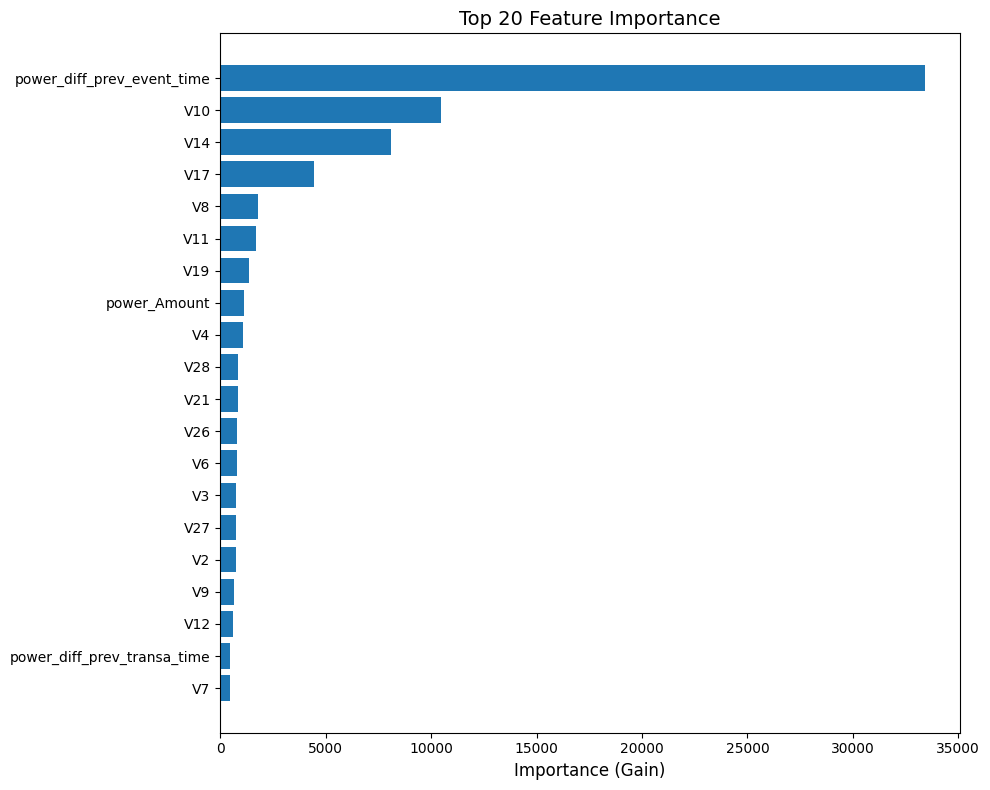

In [29]:
X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(
    x_train,
    y_train,
    test_size=0.1,
    stratify=y_train,
    random_state=SEED
)

print(f"\n[INFO] Dataset split:")
print(f"  Train:  {len(X_train_split)} samples ({y_train_split.sum()} frauds)")
print(f"  Valid:  {len(X_valid_split)} samples ({y_valid_split.sum()} frauds)")
print(f"  Test:   {len(x_test)} samples ({y_test.sum()} frauds)")


xgb_clf = XGBoostClassifierImbalanced(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    early_stopping_rounds=20,
    eval_metric='aucpr',  # Appropriate metric for imbalance
    random_state=SEED,
    n_jobs=-1,
    verbose=True
)

xgb_clf.fit(
    X_train_split, y_train_split,
    X_valid_split, y_valid_split,
    auto_scale_weight=True
)

feature_importance = xgb_clf.get_feature_importance(
    importance_type='gain',
    top_n=20
)
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(feature_importance['feature'], feature_importance['importance'])
ax.set_xlabel('Importance (Gain)', fontsize=12)
ax.set_title('Top 20 Feature Importance', fontsize=14)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

**Threshold Optimization**


[INFO] Threshold Optimization (Strategy: F1)
  - Optimal threshold: 0.899
  - F1-Score: 0.977
  - Recall: 0.977
  - Precision: 0.977

[INFO] Threshold Optimization (Strategy: Recall >= 0.85)
  - Optimal threshold: 0.919
  - Recall: 0.932
  - Precision: 1.000
[INFO] Evaluation with F1-Optimal Threshold:

[INFO] Evaluation Results (threshold=0.899)
  ROC-AUC:    1.0000
  PR-AUC:     0.9858
  F1-Score:   0.9111
  Recall:     0.8367
  Precision:  1.0000
              precision    recall  f1-score   support

           0      1.000     1.000     1.000     28432
           1      1.000     0.837     0.911        49

    accuracy                          1.000     28481
   macro avg      1.000     0.918     0.955     28481
weighted avg      1.000     1.000     1.000     28481



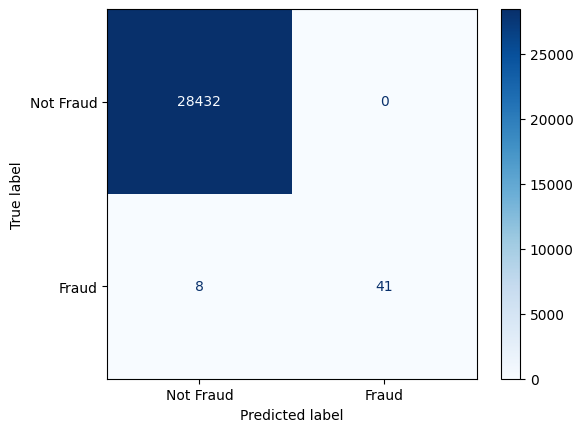

[INFO] Evaluation with Recall-85% Threshold:

[INFO] Evaluation Results (threshold=0.919)
  ROC-AUC:    1.0000
  PR-AUC:     0.9858
  F1-Score:   0.8989
  Recall:     0.8163
  Precision:  1.0000
              precision    recall  f1-score   support

           0      1.000     1.000     1.000     28432
           1      1.000     0.816     0.899        49

    accuracy                          1.000     28481
   macro avg      1.000     0.908     0.949     28481
weighted avg      1.000     1.000     1.000     28481



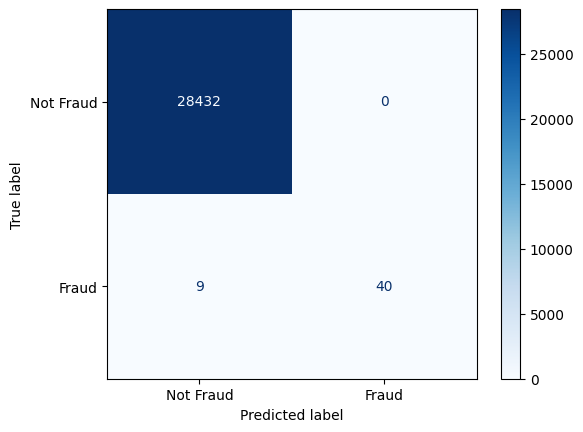

In [30]:
# Strategy 1: Maximize F1
threshold_f1 = xgb_clf.optimize_threshold(
    X_valid_split, y_valid_split,
    strategy='f1'
)

# Strategy 2: Minimum Recall of 85%
threshold_recall = xgb_clf.optimize_threshold(
    X_valid_split, y_valid_split,
    strategy='recall',
    min_recall=0.85
)

print("[INFO] Evaluation with F1-Optimal Threshold:")
metrics_f1 = xgb_clf.evaluate(
    x_test, y_test,
    threshold=threshold_f1,
    show_plots=True
)

print("[INFO] Evaluation with Recall-85% Threshold:")
xgb_clf.optimal_threshold = threshold_recall
metrics_recall = xgb_clf.evaluate(
    x_test, y_test,
    threshold=threshold_recall,
    show_plots=True
)

**Comparison of Logistic Regression vs XGBoost**



                                       Model   Recall  Precision  F1-Score  ROC-AUC   PR-AUC
Logistic Regression\n(class_weight=balanced) 0.979592   0.564706  0.716418 0.999832 0.876086
                 XGBoost\n(scale_pos_weight) 0.836735   1.000000  0.911111 0.999974 0.985779



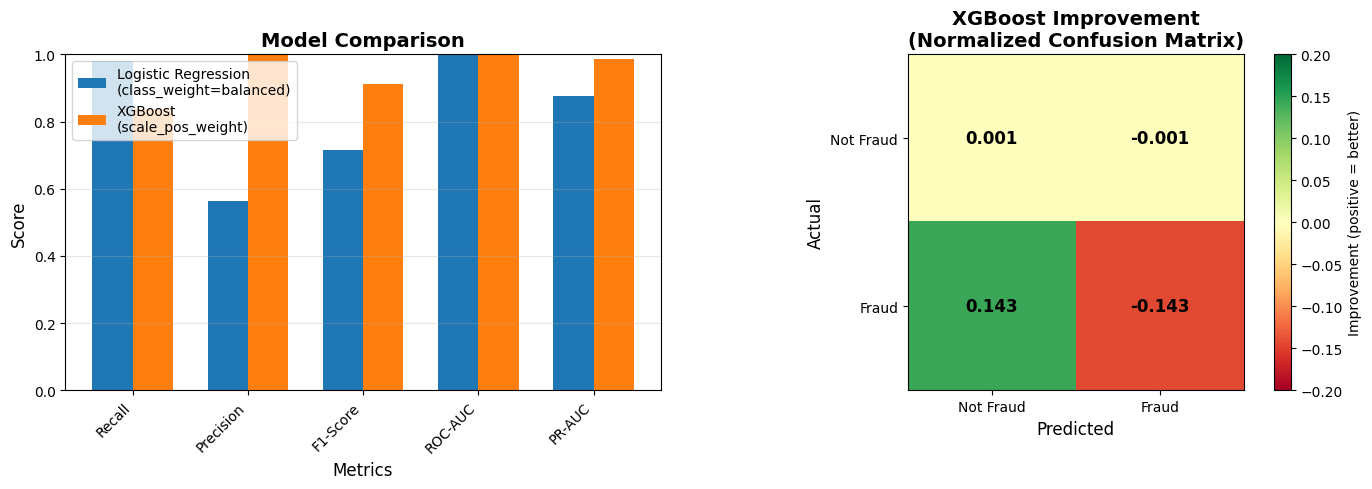


[INFO] XGBoost improvements over Logistic Regression:
  Recall:     -14.29%
  F1-Score:   +19.47%
  PR-AUC:     +10.97%


In [ ]:
from sklearn.linear_model import LogisticRegression


lr_clf = LogisticRegression(
    class_weight='balanced',
    C=0.01,
    penalty='l1',
    solver='saga',
    max_iter=1000,
    n_jobs=-1,
    random_state=SEED
)
lr_clf.fit(x_train, y_train)
y_pred_lr = lr_clf.predict(x_test)

y_pred_xgb = xgb_clf.predict(x_test, threshold=threshold_f1)

comparison = pd.DataFrame({
    'Model': ['Logistic Regression\n(class_weight=balanced)', 'XGBoost\n(scale_pos_weight)'],
    'Recall': [
        recall_score(y_test, y_pred_lr),
        metrics_f1['recall']
    ],
    'Precision': [
        precision_score(y_test, y_pred_lr),
        metrics_f1['precision']
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_lr),
        metrics_f1['f1_score']
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, lr_clf.predict_proba(x_test)[:, 1]),
        metrics_f1['roc_auc']
    ],
    'PR-AUC': [
        average_precision_score(y_test, lr_clf.predict_proba(x_test)[:, 1]),
        metrics_f1['pr_auc']
    ]
})

print("\n")
print(comparison.to_string(index=False))
print("\n" + "="*70)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
metrics_to_plot = ['Recall', 'Precision', 'F1-Score', 'ROC-AUC', 'PR-AUC']
x_pos = np.arange(len(metrics_to_plot))
width = 0.35

# Subplot 1: Barras agrupadas
for i, model in enumerate(comparison['Model']):
    values = comparison.iloc[i][metrics_to_plot].values
    axes[0].bar(x_pos + i*width, values, width, label=model)

axes[0].set_xlabel('Metrics', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Model Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x_pos + width / 2)
axes[0].set_xticklabels(metrics_to_plot, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([0, 1.0])

# Subplot 2: Confusion Matrices lado a lado
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

# Normalizar por fila (recall por clase)
cm_lr_norm = cm_lr.astype('float') / cm_lr.sum(axis=1)[:, np.newaxis]
cm_xgb_norm = cm_xgb.astype('float') / cm_xgb.sum(axis=1)[:, np.newaxis]

# Plot diferencia
diff = cm_xgb_norm - cm_lr_norm
im = axes[1].imshow(diff, cmap='RdYlGn', vmin=-0.2, vmax=0.2)
axes[1].set_title('XGBoost Improvement\n(Normalized Confusion Matrix)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('Actual', fontsize=12)
axes[1].set_xticks([0, 1])
axes[1].set_yticks([0, 1])
axes[1].set_xticklabels(['Not Fraud', 'Fraud'])
axes[1].set_yticklabels(['Not Fraud', 'Fraud'])
for i in range(2):
    for j in range(2):
        text = axes[1].text(
            j, i, f'{diff[i, j]:.3f}',
            ha="center", va="center", color="black", fontsize=12, fontweight='bold'
        )
fig.colorbar(im, ax=axes[1], label='Improvement (positive = better)')
plt.tight_layout()
plt.show()

print(f"\n[INFO] XGBoost improvements over Logistic Regression:")
print(f"  Recall:     {(metrics_f1['recall'] - recall_score(y_test, y_pred_lr))*100:+.2f}%")
print(f"  F1-Score:   {(metrics_f1['f1_score'] - f1_score(y_test, y_pred_lr))*100:+.2f}%")
print(f"  PR-AUC:     {(metrics_f1['pr_auc'] - average_precision_score(y_test, lr_clf.predict_proba(x_test)[:, 
1]))*100:+.2f}%")


<a id="4-3-experimenting-with-active-learning"></a>
### 4.3 Experimenting with Active Learning


After 100 iterations:
The accuracy score is 0.9982717320911652.


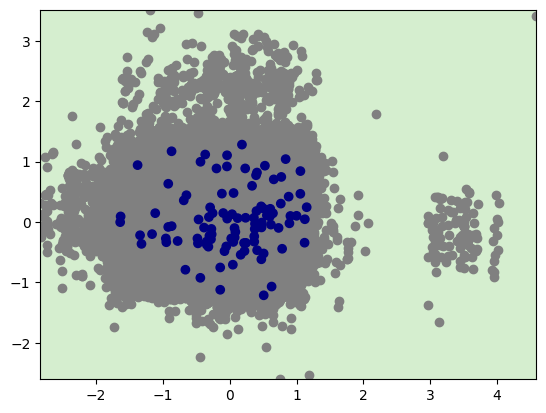

After 200 iterations:
The accuracy score is 0.9982717320911652.


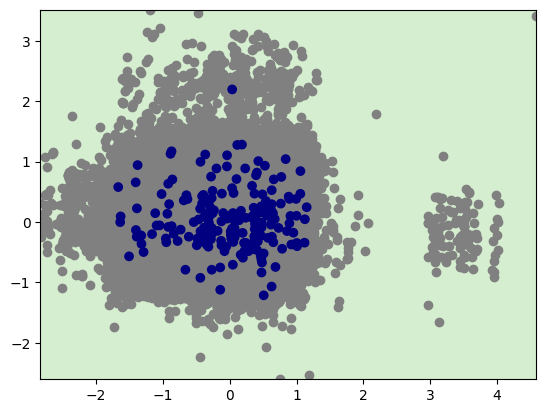

After 300 iterations:
The accuracy score is 0.9982717320911652.


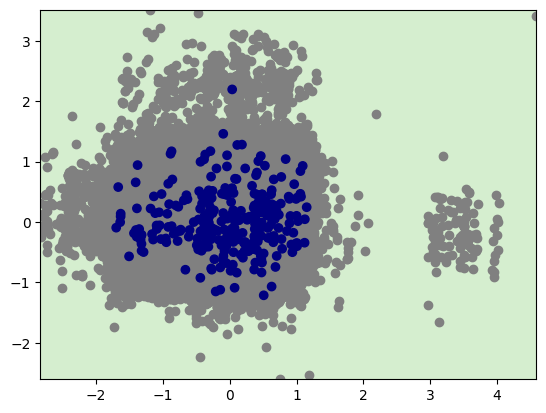

After 400 iterations:
The accuracy score is 0.9991846320700982.


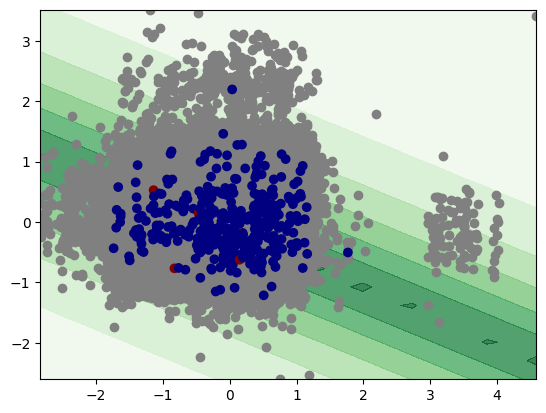

After 500 iterations:
The accuracy score is 0.9991066064308732.


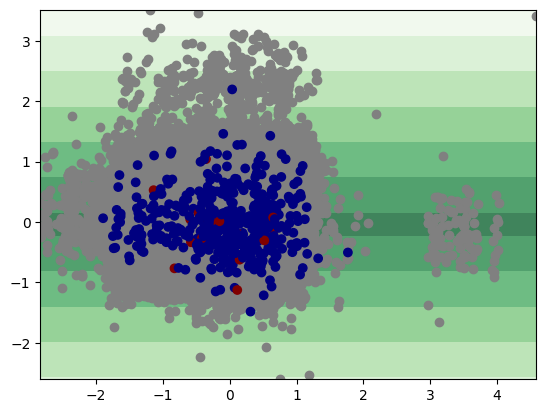

After 600 iterations:
The accuracy score is 0.999582562830146.


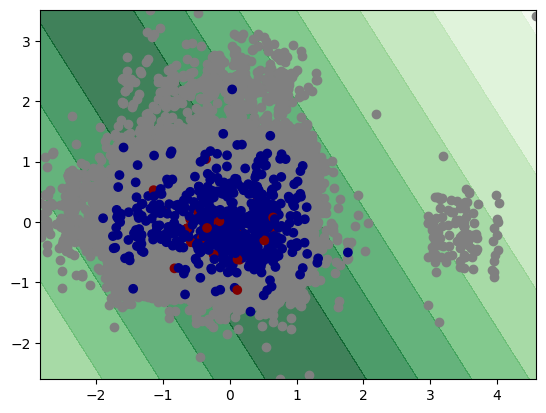

After 700 iterations:
The accuracy score is 0.9991729282242144.


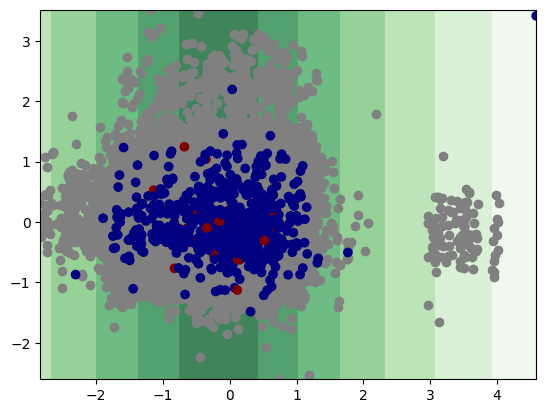

After 800 iterations:
The accuracy score is 0.999520142318766.


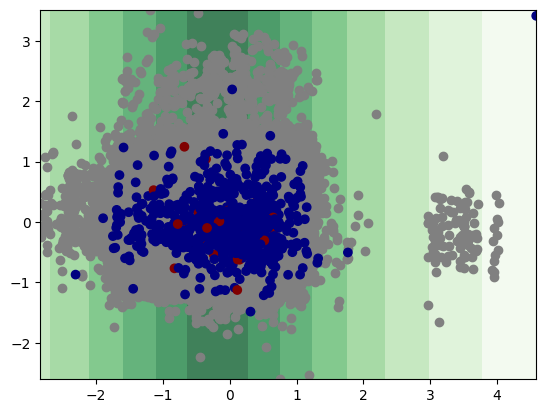

After 900 iterations:
The accuracy score is 0.9995591551383785.


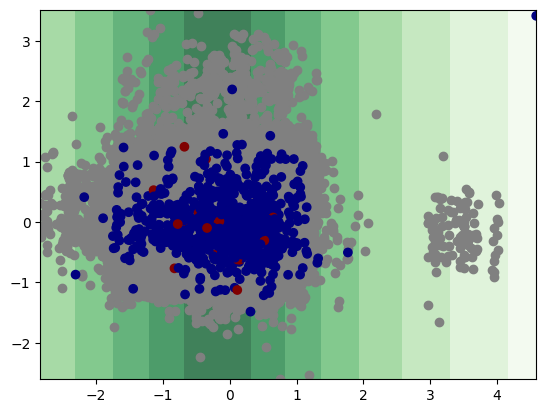

After 1000 iterations:
The accuracy score is 0.999535747446611.


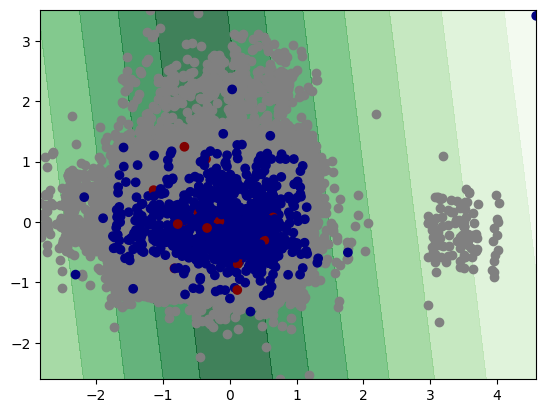

In [ ]:
from sklearn.decomposition import PCA

from skactiveml.pool import UncertaintySampling
from skactiveml.classifier import SklearnClassifier
from skactiveml.utils import unlabeled_indices, labeled_indices, MISSING_LABEL
from skactiveml.visualization import plot_decision_boundary, plot_utilities

import warnings
warnings.filterwarnings("ignore")

x_feature, y_feature = 'V24', 'V26'
bound = [
    [x_train[x_feature].min(), x_train[y_feature].min()],
    [x_train[x_feature].max(), x_train[y_feature].max()]
]
x_array, y_array = x_train[x_feature].to_numpy(), x_train[y_feature].to_numpy()

clf = SklearnClassifier(
    LogisticRegression(
        class_weight='balanced',
        C=0.1,
        penalty='l1',
        solver='saga',
        max_iter=1000,
        n_jobs=-1,
        random_state=SEED
    ),
    classes=np.unique(y_train)
)
qs = UncertaintySampling(method='least_confident', random_state=SEED)

y = np.full(shape=y_train_reset.shape, fill_value=MISSING_LABEL)

clf.fit(x_train, y)

n_cycles = 1000
for c in range(n_cycles):
    query_idx = qs.query(X=x_train, y=y, clf=clf, batch_size=10)
    y[query_idx] = y_train.iloc[query_idx]
    clf.fit(x_train, y)

    unlbld_idx = unlabeled_indices(y)
    lbld_idx = labeled_indices(y)

    pca = PCA(n_components=2)
    x_reduced = pca.fit_transform(x_train)

    # Train a separate classifier on the 2D data for visualization purposes
    clf_2d = LogisticRegression()
    clf_2d.fit(x_reduced, y_train)

    if len(lbld_idx) in range(100, n_cycles + 1, 100):
        print(f'After {len(lbld_idx)} iterations:')
        print(f'The accuracy score is {clf.score(x_train, y_train)}.')
        plot_utilities(qs, X=np.vstack([x_array, y_array]).T, y=y, clf=clf, feature_bound=bound)
        plot_decision_boundary(clf_2d, feature_bound=bound)
        plt.scatter(x_array[unlbld_idx], y_array[unlbld_idx], c='gray')
        plt.scatter(x_array, y_array, c=y, cmap='jet')
        plt.show()

              precision    recall  f1-score   support

           0      1.000     0.999     1.000     28432
           1      0.701     0.959     0.810        49

    accuracy                          0.999     28481
   macro avg      0.851     0.979     0.905     28481
weighted avg      0.999     0.999     0.999     28481



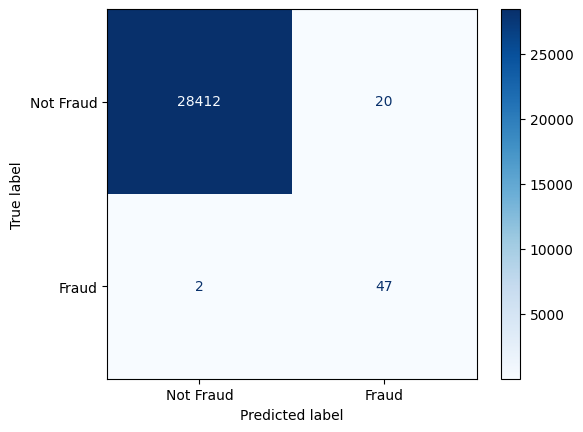

In [36]:
y_pred = clf.predict(x_test)
evaluate_model(y_test, y_pred)

<a id="conclusions"></a>
## Conclusions

- The `Time` variable was re-encoded into two more informative features (`diff_prev_transa_time` and `diff_prev_event_time`), capturing temporal patterns between consecutive transactions as well as between events of the same type. `PowerTransformer` (Box-Cox) was applied to normalize skewed distributions, proving more effective than `RobustScaler` or `QuantileTransformer`.

- From data acquisition to evaluation with metrics suited for extreme imbalance (PR-AUC, F1-Score, Recall/Precision), **all original samples** were preserved, avoiding sub-sampling techniques that could lose critical information or oversampling techniques that could introduce bias.

- `XGBoostClassifierImbalanced` was implemented with automatic calculation of `scale_pos_weight`, early stopping, and threshold optimization via two strategies (maximize F1 vs. guarantee minimum recall). Threshold optimization allows balancing precision and sensitivity according to business objectives.

- Experimentation with **Active Learning** (`UncertaintySampling`) showed how selective labeling can improve learning efficiency, especially relevant when manual labeling is costly in production scenarios.

- XGBoost showed substantial improvements across all relevant metrics, particularly in recall (ability to detect fraud) without excessively sacrificing precision.

- Two optimal thresholds were identified:
  - Maximizing F1-Score (balance between precision and recall)
  - Ensuring recall ≥ 85% (prioritizing fraud detection even if false positives increase)

- Features derived from the original PCA (V14, V10, V17) and the engineered temporal features showed the highest predictive power, suggesting that both transactional and temporal patterns are critical.
